In [30]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation

In [32]:
from IPython.display import Image
from IPython.display import HTML
Image(url='./imgs/gnn_layers.png', width=500)

### message passing

- message passing 建立在邻接矩阵上；
- 无向图的邻接矩阵是对称矩阵；
- Message Passing as Matrix Multiplication：邻接矩阵右乘一个 node features matrix 的结果
    - 当前node的表示，由其 connected neighbor nodes sum 表示；
- message passing
    - messages are the feature vectors and the aggregation function is the sum/average；
    - Scale neighborhood sum by neighborhood size (i.e. average values)
    $$
    D^{-1}A=A_{avg}
    $$
    - $D^{-1}$：degree matrix 的逆，用于求平均；
- Normalized Adjacency Matrix
    - $\tilde A=A+I$
    - $\tilde D^{-1/2}\tilde A\tilde D^{-1/2}$, $\hat A_{ij}=\frac{1}{\sqrt{\tilde d_i\tilde d_j}}\tilde A_{ij}$

In [3]:
A = np.array(
    [[0, 1, 0, 0, 0], 
     [1, 0, 1, 0, 0], 
     [0, 1, 0, 1, 1], 
     [0, 0, 1, 0, 0], 
     [0, 0, 1, 0, 0]]
)
A

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [24]:
g = nx.from_numpy_array(A)
g.number_of_nodes()

5

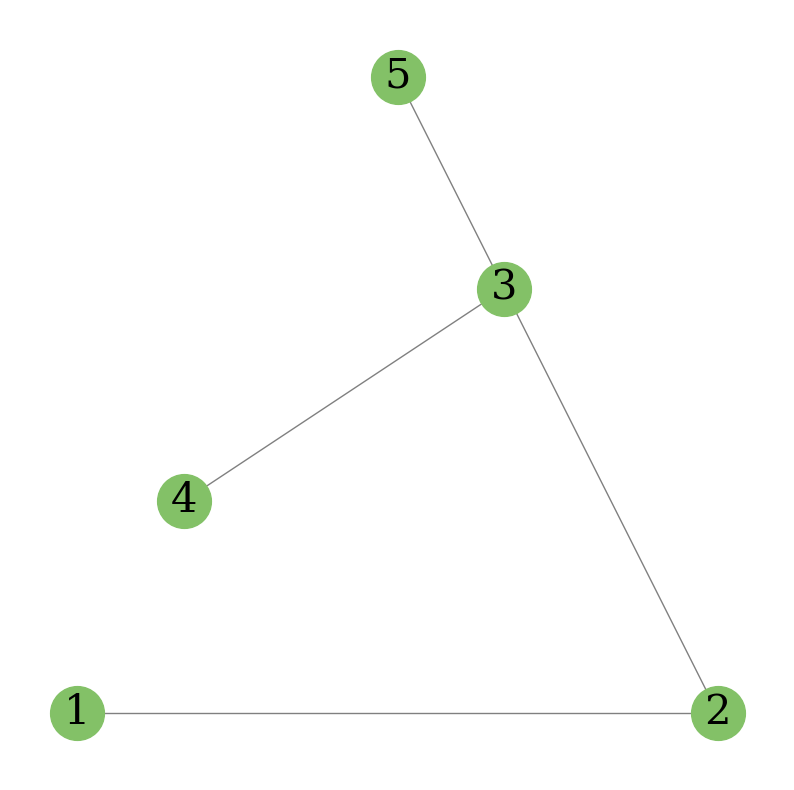

In [26]:
node_labels = {i: i+1 for i in range(g.number_of_nodes())}
pos = nx.planar_layout(g)

fig, ax = plt.subplots(figsize=(10,10))
nx.draw(
    g, pos, with_labels=True, 
    labels=node_labels, 
    node_color='#83C167', 
    ax=ax, edge_color='gray', node_size=1500, font_size=30, font_family='serif'
)

#### Message Passing as Matrix Multiplication

In [8]:
H = A @ feats
H

array([[ 2],
       [ 4],
       [11],
       [ 3],
       [ 3]])

In [6]:
feats = np.arange(A.shape[0]).reshape((-1, 1))+1
feats

array([[1],
       [2],
       [3],
       [4],
       [5]])

#### Scale neighborhood sum by neighborhood size (i.e. average values)

In [10]:
# Scale neighborhood sum by neighborhood size (i.e. average values)
D = np.zeros(A.shape)
np.fill_diagonal(D, A.sum(axis=0))
D_inv = np.linalg.inv(D)
D, D_inv

(array([[1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [0., 0., 3., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]),
 array([[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.5       , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.33333333, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ]]))

In [12]:
H_avg = (D_inv @ A) @ feats
H_avg

array([[2.        ],
       [2.        ],
       [3.66666667],
       [3.        ],
       [3.        ]])

#### Normalized Adjacency Matrix

$$
\begin{split}
&\tilde A=A+I => \hat A=\tilde D^{-1/2}\tilde A\tilde D^{1/2}\\
&(\hat A)_{i,j}=\frac{1}{\sqrt{\tilde d_i\tilde d_j}}\tilde A_{i,j}
\end{split}
$$

- degree matrix：$(D)_{ij}=\delta_{ij}\sum_kA_{i,k}$
    - $(\tilde D)_{ij}=\delta_{ij}\sum_k\tilde A_{i,k}$

In [17]:
A_mod = A + np.eye(g.number_of_nodes())
A, A_mod

(array([[0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 1.]]))

In [20]:
# D for A_mod:
D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, A_mod.sum(axis=1).flatten())

from scipy.linalg import sqrtm 
# Inverse square root of D:
D_mod_invroot = np.linalg.inv(sqrtm(D_mod))
D_mod, D_mod_invroot

(array([[2., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0.],
        [0., 0., 4., 0., 0.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 2.]]),
 array([[0.70710678, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.57735027, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.70710678, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.70710678]]))

In [27]:
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

### water drop

In [28]:
H = np.zeros((g.number_of_nodes(), 1))
H[0, 0] = 1 # the "water drop"
iters = 10
results = [H.flatten()]
for i in range(iters):
    H = A_hat @ H
    results.append(H.flatten())

In [29]:
print(f"Initial signal input: {results[0]}")
print(f"Final signal output after running {iters} steps of message-passing:  {results[-1]}")

Initial signal input: [1. 0. 0. 0. 0.]
Final signal output after running 10 steps of message-passing:  [0.18381719 0.20791335 0.20436693 0.13626176 0.13626176]


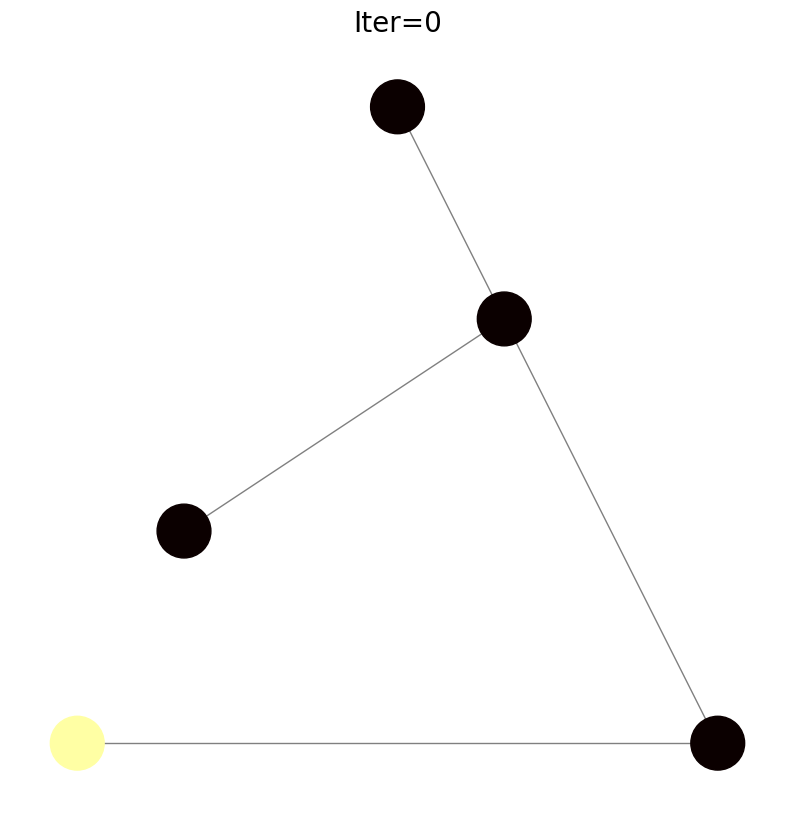

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

kwargs = {'cmap': 'hot', 'node_size': 1500, 'edge_color': 'gray', 
          'vmin': np.array(results).min(), 'vmax': np.array(results).max()*1.1}

def update(idx):
    ax.clear()
    colors = results[idx]
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)
    ax.set_title(f"Iter={idx}", fontsize=20)

anim = animation.FuncAnimation(fig, update, frames=len(results), interval=1000, repeat=True)

In [33]:
HTML(anim.to_html5_video())

### two layers GCN

In [2]:
Image(url='./imgs/two-layers-gcn.png', width=400)

## interaction_network

- references
    - https://arxiv.org/pdf/1612.00222.pdf：Learning about Objects, Relations and Physics
        - 网路结构非常清晰；
    - https://github.com/higgsfield/interaction_network_pytorch

### Example

- https://blog.zakjost.com/post/gcn_citeseer/